<a href="https://colab.research.google.com/github/nmitchellward/ENV617_Grid_Storage/blob/main/EPA_FACT_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook pulls hourly output and emissions data from the EPA's FACT database. This API allows us to access every electricity generating unit on file with the EPA. API documentation: https://dars.epa.gov/API/FACT/1.0/swagger/ui/#!/Emissions/EmissionsHourlyFuelDataCsvByOrisByLocationIdByYearByQuarterGet

In [ ]:
# Allows API Requests in Python
import requests

import pandas as pd
import numpy as np

import io

from plotnine import *
import plotnine

from google.colab import auth
from google.cloud.bigquery import magics

# from google.colab import drive
# drive.mount('drive')

import json

! pip install fsspec 
! pip install gcsfs

     |████████████████████████████████| 132 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 6.0 MB/s 
     |████████████████████████████████| 271 kB 56.6 MB/s 
     |████████████████████████████████| 160 kB 67.6 MB/s 
     |████████████████████████████████| 192 kB 69.5 MB/s 


In [ ]:
# Specify your GCP Project
project_id = "env617-grid-storage-project"
!gcloud config set project {project_id}
magics.context.project = 'env617-grid-storage-project'
auth.authenticate_user()

Updated property [core/project].


In [ ]:
%%bigquery egrid_unit
SELECT
  *
FROM `env617-grid-storage-project.final_project.egrid_unit_data`

In [ ]:
%%bigquery egrid 
SELECT
  *
FROM `env617-grid-storage-project.final_project.egrid_2019`

In [ ]:
peaking_plants = egrid[(egrid['PLFUELCT'] == 'GAS') & (egrid['CAPFAC'] > 0) & (egrid['CAPFAC'] < 0.2) & (egrid['SUBRGN'] == 'CAMX')]

oris_array = peaking_plants['ORISPL']
oris_array

721     10444
722     10446
728     58056
1077      246
1078      260
        ...  
1396    58607
1429    61027
1671    10439
1672    10440
1673    10441
Name: ORISPL, Length: 119, dtype: int64

In [ ]:
#unique key for Noah Mitchell-Ward for EPA FACT database API calls
key = 'egvR36X9VdbggydMwJV0cMDkCWdKSfqWJh6GuDAJ'

In [ ]:
fac_header = {
  "cache-control": "public,max-age=86400",
  "content-type": "application/json; charset=utf-8"
}

facilities_url = 'https://api.epa.gov/FACT/1.0/facilities?api_key=' + key
f_r = requests.get(facilities_url, params={}, headers = fac_header).content
f = json.loads(f_r)

In [ ]:
# list of all facilities EPA has data for
epa_fact_oris = []

for i in range(1772):
  epa_fact_oris.append(f['data'][i]['orisCode'])

In [ ]:
# use only ORIS IDs that are in EPA FACT database
oris_array = list(set(oris_array).intersection(epa_fact_oris))

In [ ]:
oris_array

[55810,
 260,
 57482,
 7307,
 57483,
 7693,
 58122,
 399,
 400,
 55951,
 55698,
 7315,
 404,
 56467,
 56471,
 56472,
 7449,
 10649,
 10650,
 55963,
 56473,
 56474,
 56475,
 10405,
 422,
 55847,
 56232,
 57001,
 57515,
 10156,
 55853,
 302,
 55855,
 56239,
 55345,
 10034,
 7987,
 50612,
 57267,
 10294,
 10169,
 315,
 56639,
 57027,
 55748,
 56135,
 55112,
 55625,
 330,
 55499,
 55626,
 55627,
 335,
 56143,
 56914,
 57555,
 55508,
 341,
 55510,
 55512,
 55513,
 57564,
 54749,
 350,
 56803,
 356,
 10350,
 55151,
 54768,
 55538,
 55540,
 55541,
 246,
 55542,
 377,
 55807]

In [ ]:
# define years you want to pull data for
year_array = [2019]

# quarter array for loop
quarter_array = [1,2,3,4]

In [ ]:
# set parameters for API call 
headers = {
  "content-type": "text/csv; charset=utf-8"
}

dataset = "hourlyData"

# test header
test_header = {
  "content-type": "application/json; charset=utf-8"
}

test_url = 'https://api.epa.gov/FACT/1.0/utility/check?api_key=' + key

This section below pulls hourly data from specific monitoring locations at a given facility, and aggregates updwards by fiscal quarter, year, and then total plant output which sums output of all units at a facility.

In [ ]:
#values to test EPA FACT API for presence of data of unit_id of interest
# oris_array variable below should be commented out when not testing
oris_array =  [10350,55151,54768,55538,55540,55541,246,55542,377,55807]
test_year = '2019'
# Q4 is used for testing quarter, as some plants have partial year data that stops being available in Q4
test_quarter = '4'

In [ ]:
for i in oris_array:
  oris = str(i)
  print(i)
  # initializes unit counter for logic test within loop. For first unit, we need to set up a dataframe
  unit_counter = 1
  # pulls unit IDs for the given facility
  unit_id = egrid_unit[egrid_unit.ORISPL == i].UNITID

  # create hourly generation dataframe that individual unit output data will be appended to
  gen_df = pd.DataFrame(columns = ['DateHour', 'HourLoad'])
  
  # create final output dataframe as sum of all unit output
  final_df = pd.DataFrame(columns = ['DateHour','Total_Output_' + oris])

  for j in unit_id:
    locationId = str(j)

    # check if unit is present in EPA FACT database. If not present, continue to next unit
    call_url = 'https://api.epa.gov/FACT/1.0/emissions/' + dataset + '/csv/' + oris + '/' + locationId +'/' + test_year + '/' + test_quarter + '?api_key=' + key
    r_test = requests.get(call_url, params={}, headers = headers)
    if r_test.status_code != 200:
      continue  #skips the rest of the current unit_id loop interation, moves to the next iteration
    
    # create dataframe for individual unit data, resets every unit
    unit_df = pd.DataFrame(columns = ['DateHour','HourLoad'])
    
    for y in year_array:
      year = str(y)
      
      for q in quarter_array:
        quarter = str(q)
        
        # EPA FACT API call, using variables set above
        call_url = 'https://api.epa.gov/FACT/1.0/emissions/' + dataset + '/csv/' + oris + '/' + locationId +'/' + year + '/' + quarter + '?api_key=' + key
        r = requests.get(call_url, params={}, headers = headers).content
        # conversion from csv UTF-8 format to dataframe
        raw_EPA_data = pd.read_csv(io.StringIO(r.decode('utf-8')))
        
        # first unit sets up the dataframe with the DateHours, subsequent units add to it
        if unit_counter == 1:
          gen_df = gen_df.append(raw_EPA_data[['DateHour','HourLoad']])
        else:
          unit_df = unit_df.append(raw_EPA_data[['DateHour','HourLoad']])
    
    #creating new row with new unit hourly data in gen_df
    unit_df.rename({'HourLoad': 'HourLoad_%s'%j}, axis=1, inplace=True)
    
    if unit_counter > 1:
      gen_df = gen_df.merge(unit_df, how='left', on='DateHour')
    #updates unit counter for test of how many columns of data to put into gen_df
    unit_counter = unit_counter + 1
  
  # assigning sum of all unit outputs to new timestamped dataframe, save as .csv
  final_df['DateHour'] = gen_df['DateHour']
  final_df['Total_Output_' + oris] = gen_df.sum(axis=1)

  # output saved to Google Cloud storage, name is tagged with plant ORIS ID
  final_df.to_csv('gs://final_project_raw_data/test_output_2/total_output_%s.csv'%i, index=False)

10350
55151
54768
55538
55540
55541
246
55542
377
55807


Filtering steps: 
1. Fuel type (gas)
2. Capacity Factor
3. Max output
4. Hourly dispatch
5. Density of peaking events (does battery have enough time to charge before next discharge event? Could make assumptions about how long battery needs to charge between events)
6. Additional filters based on battery parameters?

TODO
Pull csvs from google cloud
filter with above steps
Additional filtering step


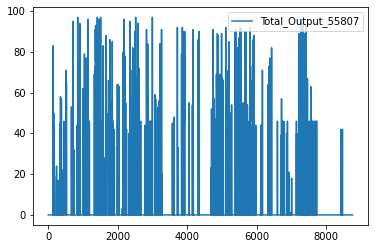

In [ ]:
final_df.plot()